# Computational Geometry in Python
reference: https://github.com/tylerjereddy/pycon-2016


In [141]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

import geopandas as gpd
import itertools
import circumcircle
import triangle
import numpy as np
import scipy
from scipy.spatial import Delaunay, delaunay_plot_2d, ConvexHull, convex_hull_plot_2d
import scipy.optimize
import scipy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
%matplotlib inline
import math
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import pickle
import shapefile #Python pyshp library
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.collections import PolyCollection
from matplotlib.collections import PatchCollection
from matplotlib import colors
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. Polygons
### 2.1 Definition:  
"A polygon is the closed region of the plane bounded by a finite collection of line segments forming a closed curve that does `not intersect itself`."

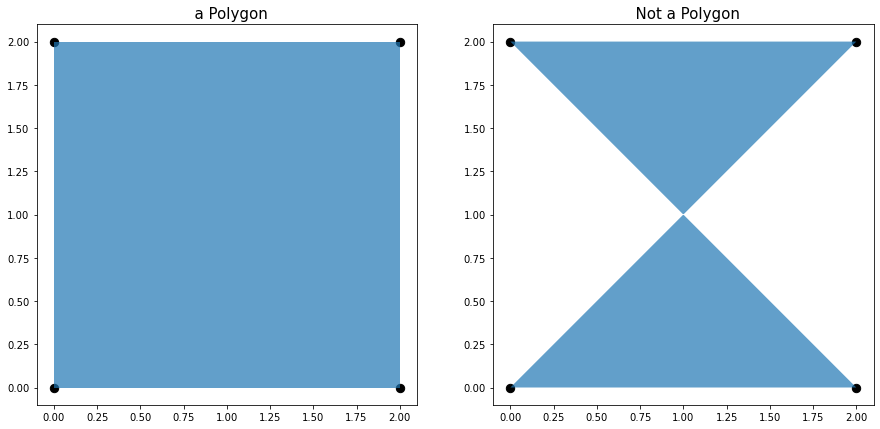

In [14]:
fig_2_1, ax = plt.subplots(1,2, figsize=(15,7))

polygon_vertices = np.array([[0,2],  # top left vertex
                            [2,2],   # top right vertex
                            [2,0],   # bot right vertex
                            [0,0]])  # bot left vertex

ax[0].scatter(polygon_vertices[..., 0], polygon_vertices[..., 1], color='black', s=70)
polygon = Polygon(polygon_vertices, alpha=0.7)
ax[0].add_patch(polygon)
ax[0].set_title('  a Polygon', fontsize=15);

self_intersection_vertices = np.array([[0,2],  # top left vertex
                                       [2,2],  # top right vertex
                                       [0,0],  # bot left vertex
                                       [2,0]]) # bot right vertex

ax[1].scatter(self_intersection_vertices[..., 0], self_intersection_vertices[..., 1], color='black', s=70)
polygon = Polygon(self_intersection_vertices, alpha=0.7)
ax[1].add_patch(polygon)
ax[1].set_title('  Not a Polygon', fontsize=15)

plt.show()

### 2.1 Every Polygon Has a `Triangulation`:

- **Diagonal**: a line segment `connecting two vertices of P` and lying in the interior of P, not touching $\partial$P `except at its endpoints`
- **Triangulation**: a decomposition of P into triangles by a maximal set of `noncrossing diagonals`

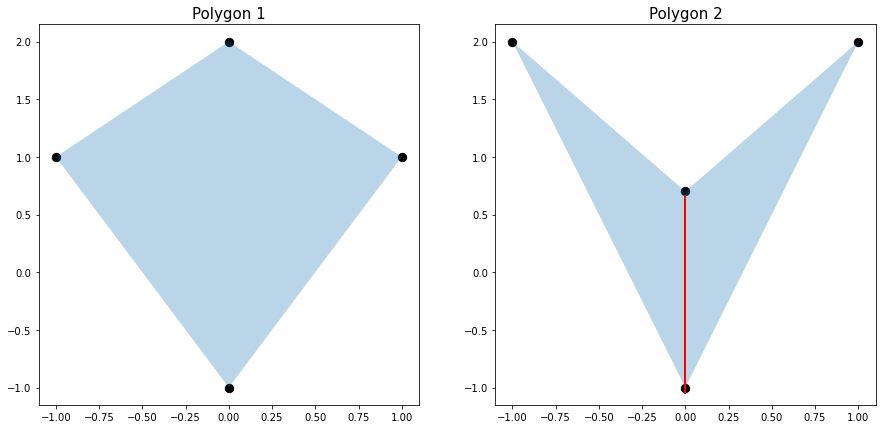

In [15]:
fig_2_2, ax = plt.subplots(1,2, figsize=(15, 7))

polygon_1 = np.array([[0,2],
                      [-1,1],
                      [0,-1],
                      [1,1]])

ax[0].scatter(polygon_1[..., 0], polygon_1[...,1], s=70, color='black')
polygon_1 = Polygon(polygon_1, alpha=0.3)
ax[0].add_patch(polygon_1)
ax[0].set_title('Polygon 1', fontsize=15)

polygon_2 = np.array([[0,0.7],
                      [-1,2],
                      [0,-1],
                      [1,2]])

ax[1].scatter(polygon_2[..., 0], polygon_2[...,1], s=70, color='black')
polygon_2 = Polygon(polygon_2, alpha=0.3)
ax[1].add_patch(polygon_2)
ax[1].set_title('Polygon 2', fontsize=15)
ax[1].axvline(x=0,ymin=0.03,ymax=0.55,color='red',lw=2)

plt.show()

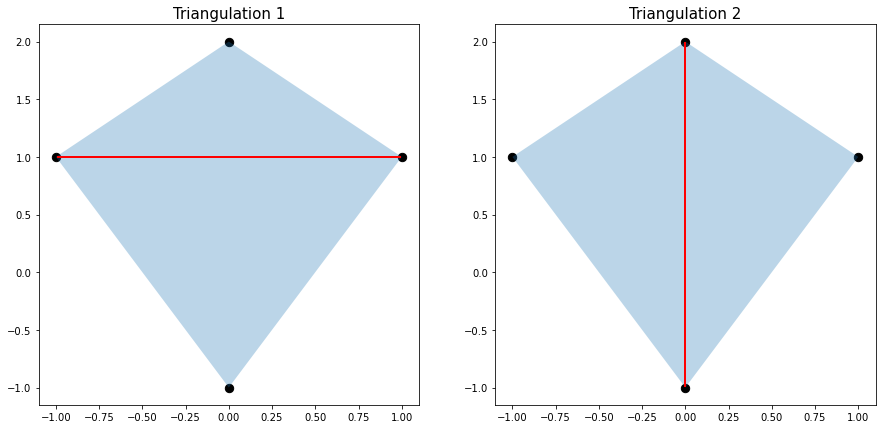

In [16]:
fig_2_2, ax = plt.subplots(1,2, figsize=(15, 7))

polygon_1_t_1 = np.array([[0,2],
                      [-1,1],
                      [0,-1],
                      [1,1]])

polygon_1_t_2 = np.array([[0,2],
                      [-1,1],
                      [0,-1],
                      [1,1]])

ax[0].scatter(polygon_1_t_1[..., 0], polygon_1_t_1[...,1], s=70, color='black')
polygon_1_t_1 = Polygon(polygon_1_t_1, alpha=0.3)
ax[0].add_patch(polygon_1_t_1)
ax[0].set_title('Triangulation 1', fontsize=15)
ax[0].axhline(y=1, xmin=0.05 ,xmax=0.95,color='red',lw=2)

ax[1].scatter(polygon_1_t_2[..., 0], polygon_1_t_2[...,1], s=70, color='black')
polygon_1_t_2 = Polygon(polygon_1_t_2, alpha=0.3)
ax[1].add_patch(polygon_1_t_2)
ax[1].set_title('Triangulation 2', fontsize=15)
ax[1].axvline(x=0,ymin=0.05,ymax=0.95,color='red',lw=2)

plt.show()

### 2.3 Every triangulation of a polygon with ` n vertices` has `n-2 triangles`

In [17]:
oregon = gpd.read_file('pycon/tutorial/shapefiles/cb_2015_us_state_20m.shp')
oregon.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,48,01779801,0400000US48,48,TX,Texas,00,676634395761,19027462392,"POLYGON ((-106.62345 31.91403, -106.63011 31.9..."
1,06,01779778,0400000US06,06,CA,California,00,403488955894,20477992907,"MULTIPOLYGON (((-118.59397 33.46720, -118.4847..."
2,21,01779786,0400000US21,21,KY,Kentucky,00,102266253024,2389483091,"POLYGON ((-89.54443 36.57451, -89.47935 36.566..."
3,13,01705317,0400000US13,13,GA,Georgia,00,149169759045,4740824950,"POLYGON ((-85.60516 34.98468, -85.47434 34.983..."
4,55,01779806,0400000US55,55,WI,Wisconsin,00,140269484183,29365442607,"MULTIPOLYGON (((-86.93428 45.42115, -86.83575 ..."


In [18]:
def vertices_count(state, city):
    df = state[state['NAME']==city]
    idx = state[state['NAME']==city].index[0]
    vertices_list = []
    
    try:
        for v_x, v_y in df['geometry'][idx].exterior.coords:
            vertices_list.extend([v_x, v_y])
    except:
        return "'MultiPolygon' object has no attribute 'exterior'"
    
    return len(vertices_list), vertices_list

georgia = vertices_count(oregon, 'Georgia')

# Attempted validation through Oregon-State data but failed.
# need to find another way.

### 2.3 `n-2 Triangles` Validation

reference :  https://www.w3schools.com/python/scipy/scipy_spatial_data.php

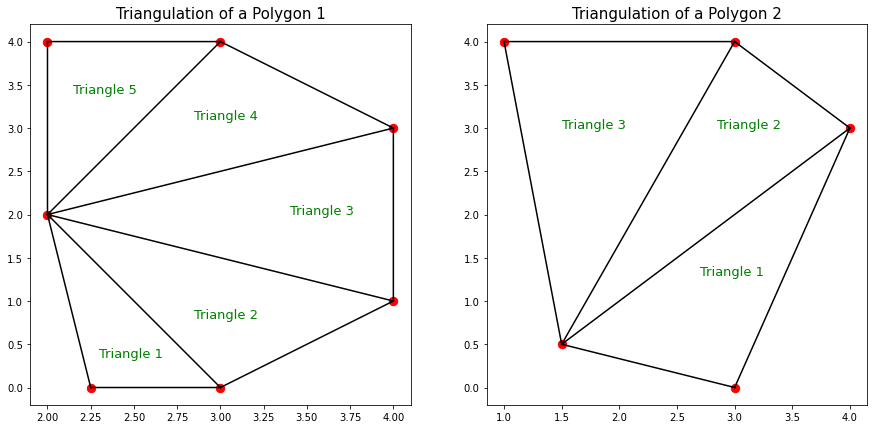

In [19]:
fig_2_3, ax = plt.subplots(1,2, figsize=(15,7))

points_1 = np.array([[2, 4],
                     [3, 4],
                     [3, 0],
                     [2, 2],
                     [4, 3],
                     [4, 1],
                     [2.25, 0]])

simplices = Delaunay(points_1).simplices

ax[0].triplot(points_1[:, 0], points_1[:, 1], simplices, color='black')
ax[0].scatter(points_1[:, 0], points_1[:, 1], color='red', s=70)
ax[0].set_title('Triangulation of a Polygon 1', fontsize=15)
ax[0].text(2.3,0.35,'Triangle 1', fontsize = 13, color='green')
ax[0].text(2.85,0.8,'Triangle 2', fontsize = 13, color='green')
ax[0].text(3.4,2,'Triangle 3', fontsize = 13, color='green')
ax[0].text(2.85,3.1,'Triangle 4', fontsize = 13, color='green')
ax[0].text(2.15,3.4,'Triangle 5', fontsize = 13, color='green')

points_2 = np.array([[1, 4],
                    [3, 4],
                    [3, 0],
                    [1.5, 0.5],
                    [4, 3]])

simplices = Delaunay(points_2).simplices

ax[1].triplot(points_2[:, 0], points_2[:, 1], simplices, color='black')
ax[1].scatter(points_2[:, 0], points_2[:, 1], color='red', s=70)
ax[1].set_title('Triangulation of a Polygon 2', fontsize=15)
ax[1].text(2.7,1.3,'Triangle 1', fontsize = 13, color='green')
ax[1].text(2.85,3,'Triangle 2', fontsize = 13, color='green')
ax[1].text(1.5,3,'Triangle 3', fontsize = 13, color='green')

plt.show()

### 2.4 The Catalan Number

- **Convex Polygon**: every pair of nonadjacent vertices determines a diagonal     
　　　　　　　   　Convex polygons are not adjacent A diagonal line connecting two vertices `If all are inside the shape`
        
        
- **Catalan Number**: the number of triangulations of a convex polygon with n + 2 vertices _(Divide polygons into triangles)_
    > 1. Number of ways in which (n+2) polygons can be divided into (n) triangles
    > 2. Each diagonal cannot intersect


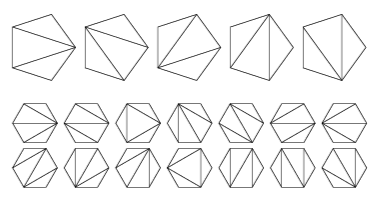

$$C_n = \frac{(2n)!}{(n+1)!n!}$$

In [20]:
def catalan_num(vertices_num):
    n = vertices_num - 2
    facto = math.factorial
    Catalan = int(facto(2*n) / (facto(n+1) * facto(n)))
    
    return Catalan

**[65537-gon](https://ko.wikipedia.org/wiki/%EC%9C%A1%EB%A7%8C%EC%98%A4%EC%B2%9C%EC%98%A4%EB%B0%B1%EC%82%BC%EC%8B%AD%EC%B9%A0%EA%B0%81%ED%98%95)**     
**How many triangulations are possible for the 65537-gon?**   


In [21]:
triangulation_count_Hermes = catalan_num(65537)
triangulation_count_Hermes

OverflowError: integer division result too large for a float

**33747323201440556113338056162985588357837875086719254529204776056363889844905557713739048340117996110352921700408951100919433940915769499462407428004752011383006419657963144014042479281804847015572826733723623164429057440898781532797597869815484271075717444684570662682394963408208629099080715745972772946006296106499354887299694402936319753107045557391740445863439160648262001141872452050396588948824465259975163200303038640056430714650059133450796261891032284598017854130128705295226326771545998255504595581964903787472423750457206857259913504189304684939640125496939691164198079307649525960603208631067317975666087499793971587417296924326148219991968402007732708048194308385639765795062086746617174268472543023866024248511351083726209450603555886380626916052013859447519902993348887796932314345276891307538484736421687825391628640809478840813305578682574926433003601702463472852911043608483630418615427003880182747331593679315417192039482123533569719483000440250968754176225549326950785042098699610113101710878897892324308772294967855423675750513298583186960648325532774424214890507083605942388848953275619401724362675918430710426975290691360506884653336621653064690892329824732925845275837230176268495691439942578845868938643637837142788641859506216595475847303300002357743894695114912058095860775609082165533490128147966257310220747246225352197266119675066529403323718172463284564846561515902214961442068347629452357735281973460365712773387179589643898160210925665173486469429257090809577289103806300560691024021868483288916732280232429033383791804523427619913581593088192738155155640689493245442530327824518958137187993095893856884833221704621134899433981352395367589264888033097666054235552662092420733768975530998477809203631438016272704775829523113286779065494129024488290879798931262712838959860387988385921256798404115149812776446387864099619976334184981649781953733175474904314606510455389119458055332710937299173499999020246609985660288903275252681763417364466797820296805596212806591886057148195500887607393539358593991322763610105244137640257663940551594721363605426381268669198424712562157639506274867982668696361068571216091736355764314932253465574154553869247361289079532438719933095238850941912739324061862359436582033742234588919928940664098633424752500402133144779058266756204443778506162437467451584372958087719039361296158334246052072002526339358570474632968653447417064109468960990192115121921317126726285381017151696476109811823463073953245952773212086468408238165863253741772013211565054148459847293731692995115870664092216851538843447102427142239822023579754370473404954153464100832146900148902348882561100912244276646696476984140479461228438739208634307437937458460535626674720659490920600264268924423431774490791859095568373098392043698007184166500542024223211412448558443147168128923502459195152910586068113407441487252811892512577165499056781544109856440089063699466442986466035617079143709531473497529098943302873751119240639226134143874756814557254363412326147153359980247205167376551085684959010985391497040485148850591713335318641457376552268088436825597470463352673067826600599688190349874909218587280793794299777603086879231681747404835481274978721014443077271465463564635241751931183811917137900951050146715419723250002303577581667818654515128040815534790615451837708388768073206228368325199768197792772897098823578280187829771178025197733126120058811555288898570048066545446906923677205068859719468230599701366050603679478057322007856839565030758286237639026178195721500266385843373032766966241214023406782331913455035655030603496884666979425897870400738459962014660342790133761583697947482106656403154265635805823984933117221117725670516201409405814030741478738332422294495023701636610844992761458182973748166630014288329495508475532037190833762581323750980700429440518655161622043458655014219317571399149337547713959849133378618966610650639860501971693537591360290733068967126648140648618608272537235085706790227695953647698561405401378937939475942571581128437970879240039118512380386758451580248459824342581075558256034126000842183676288932288054619617648903766247189793106020217023599702591866761159230096777143028418318151173163677828909243021512253473816060727665521645606359622135698545837816964966909571702155064979816995562946755050691407350513059397276307656527777414138369384126637935650723519477585381459919727517956981235322502851192881786476202450856595755635611089213056532732326103995510442351197895368356023800651243466512190633596214640616879828416572597953313438010970451791702821359948174600903762898906450769218539752179576932038647503464372949287745091343190548957294495184918233980109134667687333637174150957381311170110590611298663119346608720381555864809376823639985408428061929655589749758188735600517623065184416962717246401475499958060548500102293079833428424012509045360950799815286881632927288963525731303818089565115343422999653480631005257112087423429594307521186573728944525209994973577702631792708356582008549145429900828404552747258111803062216262864392759592705453377158260002353268421318060428131677705240445447729865528503001668518245011977952171684404570964831418548264443373731574028779232159690892198522078483660206946682587608566820825601714583843959003937561048273487585200622689646261476552683899549754541826656047414691534868959241546460451185705755052294100074124070044918676370468038183944588229977713329525230382045555686785683848113307083034984108897531782754654072841885416148336933067527347688419959693913173358015546637953751214262870495081214599113928858502008064796387040466983808866211522609592378603396195772023105525518167774929560460647450783122522690617015898985113215696105256066797355195107392374003405683969451785755407747045706382953468733452151400967432852921057933614637793501123962843426332766461212083180179476006416469481770819376276602495991896193884111245388330311993982736275591262829346119953643663203743370704637342131050278769151680281291255933805710692912626528183813928865942664135707486939713427911911660820544593850010999962110801365741506269994069989794552879414974246984705842693345005384245176360300294319150955115744308067839507959280490551436119921413654918998627318204584378447962681924591126653069219026482746075254686386941410415513051839119466251347472336239421587720480449008762414068421391773260438443895958282660118990783616693591792703527960009363976623243907103172479213734272083716642861911792471158648507350445916981987499262819841166613925430808261061213327203847511488806675099410939373764872621796091566894915009438870274701923894479197290311160505888856348318051274179021583601571762419237749252350787262544242671852798670729252588325199621722003885255547738083408648436885665338738122155400279741096799398994046272164976483389612399418098281161553032303686462335270798413921603650308716627260267540708647624425838720200136635661213356325859809536524388428850809349362183996148078013515667289514026070056898310870635052079295861179311773123182816515310709012178698552292571913454902559728444334683737756627918575912405316914629248484493304541868982340504734851126464363779450282214584655548198359797362051304953349035897843937751034206284405674142322616229129395038501812687749209289424418517250097056759206601391019628308475532003983671298452170731122341038727158637814386125548350529992881327853705496055459021168482181366711803787584609445377526175740819848113731791439160646271960716447146358100327554964235913647174055719795129250016652825707988495401914183397378314488212135620001598554169383573579297762153019593336411062443944040834377320841416442373449651043987327293712681018600296492241060115049105082431249859034037991144755257553024733698631483980317740063983829834182229938062802189652106780170791206762305888358532898242453776622396575370393488633612526249633314324318595774510276498423811695068282519097568700226853590124862543966521232303431195096099151872905362628710454681439523511336044539590743833795507493802577247200756668505475183137117273534556983178134614457656650820306870569865468726241248051757153821580999274971423781119852560685689274151062302643353296701312445086034665266530738722661433415922879491185115832411150443593936570912639692769522842692426350740961829299307793496152591457563565330360613396363843528891603977956783901461206918692183054971645018628228714594255688702924543269102918133280678228761290294962083458003536498430898388187469470183971606259269334251282936845563733717754231596180841752897412542663565640005844200605880269905686030929620104283982049833775079238270151413882378838620892317974119465914375690925381923490652333387333211952592550664422590738442071264322030117201652209862394554764340205594181009767690452854044209661404472057099013155195722827348704526074676699031049581712524142768530549067239934844812043889216025572583386592270354646464809171054696087210126848999700864203949085049090727452881626772489313496390736950660757792943944958461870440501594579525843232039927550900513928159534784371721264565069103573384220962239911014819595869013062712718879299728484862258153259950623933718111041768803822965521665684003537685116598360052972466977516475388790725039107815239532628035474097684007699599115494227096919309853270122771461078823905397471202993032310640590677104734337936482327509558697738981254373975032410572362197474602818022597016489410827404266321401759575527682636112549702975392685108344704993682150188140533704761167846247259802530233103468696280679814537640123988843902222535289882874611082936098803998272645774730439060797983686631797837429950877630521574695330943244871103756482976641025706481508162596841746220167076483240581118040383598876643301856779805298439228786950134672284788022406714601496296800903732272779171372799352487179824711416208152442342096431055812988146806769405014385937234812623801211862375063338913553728644037895353117613634719777842016467443674576485445126633776688773581153111662475971790152923746095538870053169432598401583744436880092563504460402756450353624128757617920810799624900102710588606567781319687165283987733694202757001530028158161847401152005759764913461102953798605128664526810610549072008798869704195356480981212610925405811083057727030780813525431722404118960308898679409280399387419753465809591140140609163575553978544362834627818404771928965220125305013130982869984791558732213688723110338222447895095091172971793051649380675581112647822147611286549137880907169221702438563784768706177112824469274807788799924256638125842331100845054275993256697921219333723289564402115106744061060015575783830261852980602690416992130431635802928397949792875655384742152337816668476178581197445462120844493677018941627714604230932910104855945122654818462430677741405778407055296165659572382987081839100252770336513059139943758035652990010069477640878296402989238660435934948783977988042235210004552123905341706464593645645770476379593767071522770646086149596134443446572611858327020317647501058002311610263054681091193083022618904098362465720762816264225051099031861615325338649310727810686031258270152267443207971517382651902461030163110959443281241343875169529260147461495129886551094966797142261405469465082097880284151683636682795100807237280527000747174888114088800844770676638290622140057362543955372369324513991710572644870218957443587951300436358856340570322873941495358923392434111113235477312912805833846069347875332275127754560266259079042046447833916493488062181731465715760831911816982836668501984456917856407429083288465693250741874241700616265623803593668941717030814253123147834256440012000244080570982324338899160109768780301569271780671559354470490042031964865153549487486295301945969826491696017856017759918250591146084123761742713874405451930937582812927587050761667271268271829020027186600620097216918347141730332788689061212617640188985161981699653531004129296068770534656714225077179367603287002317524324932994088671411801677654790195792366232182301444844474029250110261700293994762454321811044547943196971055723376091035042808443814870133982110566594162266077233647180847978042324185502189640708774007352588225433912048139336203009420228369457352242333697001252235872370240846697507678252451503915614570935274817649369980966710001410292916536114843667446191980228492778359421478444331543259124725885456890910342784421784013035191111103231068791327250458425915334772782703252823013662261705894413274243082295714277896527318735038794855482237606882125745934156646626864287408915033344699644600650442235390076016677327685893806449869131799266288764689621783710120656806831813188580853686654058636409846842115916209446476473938643441696248526888517568728057717373186919296512746569958837113322054319302437642746095214075790775710806058499538716181321485224835022989934604403872725282490309709367029153828005982212830356180136096069321265563731108120423644497387649291218564020984280951414817359481870831098099502004970710212979476320897773789102100836887204206050062416456937167438157237779391679884794498297232767461481938181027306476588134200604031548377499733594147166486399821588699065982484070124594219134835247545665140981110237492001072756118295431114687794185906529344638299451287813369031261973820313056621022506220057358818957793677938027938898233991057252688543601173906509190284594083615195105143857454212937466263441479865314235490108406482400153477326336760954866671943670156530368372735195289143925634448739617632775047241864563319148512940395716154091593306275043559213491399897310389206977157603855258000844707602787234619419897997213884544247600634789439113338020520698017400956164275946178827814401539211496786658775266644147754928355367756179937584662184161736007983578836850238174687362286040084738200755257786035053754003823160472494370941063483012562365160478174499983956579338275171496403244199936315336588916853260008682314176933076069644703385074037187851607256132055069564826126617964655524447398007191650582586862103902941869306979254315430164768960943103569260454733031979019718845187839972403696840874645456191947771341015902014740951062850528499962037982930395233916427181257525901456226195042098096731983666735742189394485112892211687319361937660530108653965307697102522925677137247230132427985520883527902758711342586230063335179785299256432044448387578880041264100577019788215425382182894968517423672617881052627900932086567178319386225416446453013008893663050000002667928549212493242496159496899768165094774809483396916051905741845457116376318171236687684563034060532049857742820643206055686114793622136474460656979615035648657412954582881394343521591474852264309896395316623249391284803034402296699458092983920819637023712275696590110488534971992233898276575271151266711420923881795833922290706188908914340766849859153827874264693506154229738589971544010160627816051976710158770085879523156220131612253173316506947845540716637020896108051619908399106907972429285166738428896401373200686918222032246524305329764934685429004596744189932280187656196090596522658209946313778403257693014091350298672158272969200319016880939781280696919314942468038925211977666233066762582020309274841267236619524548892784932562991959602795044903837428171727591480681906751608786390852533391423110720354260003608077082268570380948426273827769960347029463560495898956134372477191322557157231037263223515454314751818264073706661479533354078193606751091307384756210034320035955179202790606979840814410774229228155420123003975911241546737248908980549787373811045871230550507547036629972345754727239463755177971606242017551763643682214564818730189879514629478724288834690358031979085066877856614793092438232266746217500742313375233088224113485938035249075927300418116840381209314154473974979952517900998244534986557169953260374571528224624336334256402796134444440634226552142912997175361540619398622440887201145098342192605124496230460701798202328092563708419169883339579217783050929436575325059021556119553298800127196654140562480564869293375292075364978550914224972938585421881784219705787860688360209232673885572459208664412035771472214357090064010535294377661799122094244121476397378851486221348081574877961816151870070894788576340608152224274147852302855636562928281282946499506321013876691498448219397410515457583337238254197224881444529986712528931903378755446028609683886255578278635970395280266538545416154030053151172380662127954161248773237676619268528266183018150130570052070395047897430179381418489921208526298589251716078889894798895367560328735951919032132199323407727411235278269697086053353428459147846142272086400180276892254090058914730696721336100615740628570163937589755047524133847439845507787706069324657227359109488567284843916555889152937380818801732892272795394176498885107082957261652966283651091581948088980294305842159686597644647564928825605935201746685502312009882284218916631086739423407721442866840619530586546970381121259896453494979927537947432284501657432078222837075952949907757039712797310912124631271261582485032585273795182569172139630131516466606797642863337897615213005620232339264328064256956056037386340522892701727561776136217891618272627859120228054449833865018483059168097865964326960342624093336592723178889355051323315612744971886896151030103496143698212457519070722871479592704500856387092867936678319469158073921473948877828555594093504420724904592163584604370902597311430927020423895242032102480060512509740518066031312840025534037563676967409823336209028109671652772032629188054908717084134730110023455799264138267718550454423809722488434558013597785408001779655347758757713529343989495935505744154729742648508485011752629685972637599431255203351743236935450889643237603062059424653864157042717686750411285977188570070124441144126196939751222583270388388045761976711377986456351342123258364892303473752273449984490396024624590993657346433480191022790032905965981099979250797874964766700120452679755811643133139039864755533630075571694529455429312400478870919703015545814740383914990578688575167066298552394832057842257910979530702260982532882076228564136666784559898320060446281804281460264358423281825445053568122743141349453074430669211098984068471390887745668738688402771208174144068582857452189600845633069917911972293357144253176300208307516996411405680690371261742655482678253739972697762701480994471383289065329550703499487852719064687511058742495169900350998342390657387226868825826041301564071443642426272592015741493286194882256092388217885929769734237809717536073873778271945149898140259973112778393147093412386558276878907504743633590975620654210000456099568743880949632129427815025879956868945352223061340927449012268214919833601854617033443397366493877425805437105004981028945765075152884746478552926354093071617441804139103237990004350895163589851137091022809456929051222554597553113542246292387118185426260702175714625491929640427226806666721626352768242086578934687964506567862865186417974371231632203811522702079281659268366895381236289890060241188807915681683067897992268794312771826717083242147393434614060374324341670386150249994063409229911310943189598516845739497925448169081039906719524869139492873124425138789631355871952076800329445307500865922694111432105874748309814233440629375225341633582142333311985173263483150813271609851555812131670328486390464111520881991293953249249462090121340515559676969977131549190050741131562070863931679449890306137917802931518149245480531761400330932723986778299865567152233524410442452529376473867805608242777846318392910329876462640957818186490676977126402044001717829497823990061609443507971202948946725357852629643486287093976825453121747575199908284685252275974492383096781871431966273540208756347016798375301940426216947118314387000881759957478295874296874820673105392589416977961550343745149592839819676453448894794862263545759089647815467495414901700999613081342524790194109598909097391008447048705267510066344057801867330861000801056235384927106597567862603693429228107337450004271482328505750435950981612546944158511503685539808615546272822706526529489250971406659132821390338495897405476286999108817375561755953990213779457119555484374285030803805763341157078888979021839286914708045290592661662594419429048013891220011413103697903300392156599786056091119863060313819258403983860441663598635727393003578123209404190340697624514750138130762778813395155326068021808857320853842853046178509128057813324010258325462716422964105410049454225044506585528501133999046555654413527291290003967909416765260051256866142711367025563430621866537820960865073697178767011163501772692849022326895050141971938562560175717052610938166301711602218459141987604994153272162173581611471676938424359583440748926747989827418762486476983532019720548079591702279858811617231872929882794562172570178121225027485294171531930107814880626396358575770421127333997436891197448144817986004267795677933528549361175035481654611246189121398214338307641031926526845034544976472798745091022307927490768542000302512328739759272897002473770353258866591608658686286296215935462207439985785355570733509865574716964766905751804511114126221284496183080600025582292465898202369358969853780898755042571141346348975447581044531995728128457528929230224509130670659185819279348840105474290174863949599653665590967829020743520078888746952225605331193487608548664916262180647636910870164738445885470463338785231345602058963684428534002410742709336008188655952350444768227667856998506427749244378223094192678580338796677071399112021544513871855808501288772809813328050317695075064745760598113888915329832299315931253212270865719410939780611140465181659074351215826057175302021897668654431814235580375600979560299630055041890724041644120632371358655698231179192751156160177972623415242684972589759003483786055566253143007729308990283097576394679197438622240450736249214029057644525641994793240895865918154082997870546833649140852358832510365674551995636847103245940575598658435521147186398818945891286127508808044644788419907255568196318327266494709702060222495902880669170958733917011704246892285013625057848660015767595530955750618154138616067334275542191725861993453821853647710360156846131636837920584313941390484177014275131538342713094007227471704631261711594510238296138618890077315226991627570875631396452942918616211771390303512241876460466168570063096270571390096645735756791793381302567400712652823001044016954218419406006147716376961842039600694899330085186928321954922433132351694772121974562664628041095205867995415523972893815206734933473731295190395402112663587915276004068281749277588396659204783406295147432654425422056420084486452486347431370015021563137083093845010623305717211348567419391183684686373820593027347415859741992186893028175468687174831541235739017576150163803973501096930869335419019938376855414946351681986778112630540374393297995549308866365577977739645086222169085483025887111357102833086242246201540742362592751188989608030685365901443148170484046670655288974437198997755291815111431918007327072646625543464029706934539284603387445736345128580739540111231773968093407798344952088886573682036786361811746501546225803015653855762734031655800139638173229634767542388312630790264742628590639065659017275753186318440896461589174679431744202281653926331022406064970686202492610126017442964550997557734989490363397690718198841538831774873600859034610032054111121436581338328307961043850624175893662841645410094510479208794521830300325844643184040447908942265775458621212265284780959641220766647057465660997142116116968752063247867327937944158636861081031438253632096708335192489534186919873895688400087813147266039116523360725847554182233941041157351529045410084352940820092015327194621058424603662534380965804307770601689272213050595388283281706573771541958242720989849089378158421872748964230951542165056946789935109889723973548178512392914286406076267307224202941602325984128685743495117572638024085259526577017290977835249974243041724494060966576994272068206016943055046450529926155551750055206581532425930524039450052438267186321164597378690879160932361737982768327058418591590607917673371381206544351586815364983292285760552436519761863206078959878381046976146636445144881022619845866884308851070171660288146628582633371661818289066846496173636012646601412088541901511690916871958217277051025664984501179856983625003417048138835741049891140336303211920922376797417421969654165344321795897048071573766623085075432151934249877323541160558138709673763581776989880294129558297806817169063711692681074948860173773758018286375245604319541220888116482969485162176348738655840358771791449321884574523038151373850715320751269227917549858576131786134339103472218575371850955667915763174817754448507925616155680018231095906022444112448741358644911533283097095987165433424397409216600289746694332067584574851272995586803738271328601971533927619072126341628945263336760050642969244196679375067492462885864154403637754193063948420652061968212114518477451086228773675110815943281810278655540348789871914137959434399072600617965544076089154061123102414124485603751230766437500317926931789794098270251193184615485360672661609626292125860956533390378598339658819029311937253647046129984585550138161728727215101590261658446949632657080002652184766522849422817988955244017482147169095241722117100886938910946880837408462490024880042675817974731008699347262247423961234064659921580909164768193628432767229939811719934781842305420182986301025866157176856159854825636071158968363217455527507483996016942758149172182271474207440687815626543994602221650228880753089888538579261724010554334084862355064455867715854134361908077319728021431326941032386851245504667974138747384594676160727803114046257022850172252542064727421946475021537439048084002713579418836022172811645105271312579025066359433067440420822941205604565710812063475747415580258615418593848760675162568203290430634877004385088259654587235537744126453322465324914596188103356434332158941650092151845067332862310637649967252761696153974700889731528422712856194710429156717788700948019018919500973473960789229160142346548115298056191647397173428368813572159264686053280232244539033810727004784567573946528278145499264672714539564209367645681803428774569894907420438484623015085647861689893617649381741324749767753591049760228411248880500687227189913787396483339408120155879274935118942578653781940974516800379672137440433442773629047186714470141809796239778010043782972367944698278278643436855838329283429566506428002910436474832854355877123668388361622108655607555314289867765747420318124934068593136737387467956348485216791034368353226035484289079350580437875069440578847227195880733982438244816903068753311978916988968100551180821867418539791436743587029389655861228930569248005697150632794040241628508281481428388238370566818930372620951535429731635086139787402313188926900920140147933711098035198149475165297489830381606028220358405045022611033858524197673195367948879334275019043378829533680108788036126523937084617853762813141531525827863971512477748276983750660676068484491462838809870030221295416707007183296757226159241292886037052296745285295996203243833256389488849900143545254451287797586321723728189598474800345103912763961425522520096628939280293459711339614306688537668206060197497004854897734796361174472027730930847120698783552502193278746962307619782077225484432852624652742843284663481837348696934186098447787170202513063845441296137694914370847731481384194415368533636261280747041884245069893041482636628156631048571165728663240949770120148993874069863114446155283997238669722696024300876023121454454780693328307481124616230125889568090455370104961660103898929941315838281932248387210123250294765386082943253655175933014577579202792383940536738649935847021435514928282564158176109623790231362952551826715602413388939801190172514430051591061078544742471853665029129594142195711764413828559307334234747411224990018071279568684711350324672456687730327930431809143555311498227432518182363355699749800296954381900288280325337330285373940379082831330954611637982099427515746652962635169046322467732832091676174008453566030279276854477259192133085815610136175810499273891257727609560997639915683640890000402009530365689785082019939708622328902139791647158225055912632959508780597960512881744759302737698003140706422515358479741534776002672241199717825637697810429410496280766076449137653777974433353822810096281664973939270276726529615469411101047202431529788533967525203967328334342129646458139411002723407856394206802133894634655029192492885876184286769889913277403711580043224303195315708270797198731260782612343324476120210782293453814595779152358072712076237438843121056780652093540771354962152292803120409955377708012054317585723516041369531120440182863985354495486121987068911318708679638673524876578196300082253900325524709137033533063952414277618383756730360622538778650480523648570749529560972403228366728922688995623025557355428873249937112877249648129555103148168412006654936156654981227172862352064916441396717575093031398761782739912632682063540020199800703427693656983651259703955413686466534612018350916297058253156173144605916819823703253846430885695026313697756922732338474982041134695335391469160243934958225484838287059506645721964372142348164798997907822919212980725292293002890662236448775394221117646535928573315745702857073122115017184013310546642827282787095619691646537448465919793237356504287513864449291476004118085126428367980029798947754876379194288434334905236478081425930781323785298791170318987173744435280627621844605748822910744064534977674162580236394224817469010776425445659718165920685603840829807564569797285042783128905099274912305018440686961068404634349607864251910457110502178082476756169167596486245642265819510787278532226258664325956154008733992152230748001831624768985202713745685356390480200708046235550343108509462459941443316883960489419391329657118333217189713065985528437993555334305083388376864244839040465002899347152788315980198857897513745867288682893533523699005885581508759912127047261999289424667402622980889195141325967975050125803725863874056065396958579445121339011891200098819229194369574703971030482729438928014223624013859459825626284009286424395267541566174030179397103934014711683325462996088208691712444973091468285946300535358865611306762921130498965089341134315861603630003441591381277771803519399372183507130452700199782266311390258464480912344542645004386281937968177682801133348076553837425676229220590705710978475719045228116575108886790263844754875837652121202260294853541580882263364778040584719220726195735444305281151164382223579059867590000794878808765884288386930213903905946964070521923247195032467173278086387384655743697642456202205775402919288008659170621370210002152888477160854945914799421754128760736704017768051443605450342619051842339862371796819728630390646258455077428329494539473487273304026280494691500187034533802022292779047406645519768515269946366674699528057527820184799976760820137609641462297277898876863853337766574334067281571495069103962027475591175739569569437263247652501869402921083026888227480007056555928369650645226446262886500936457697801319376729863040538133365903531812851773795879220232004164175645838948837728757486505109878394257206540497193849242875826678652479610429238200011268477932699407187752710447779431312972702849693171453351724601936621181551646958094042192895209958908815429749564723412916526588063099516253725200189655415708092333519055792866597026811243001846497014639044041974267328907032939518448655203603754358882076241825924481514554631773937367283705541621257337032122348962043042184658973771497667478373458666395227550054026340348023608813989843798032677495151801171353216910693109385005610215407847296962173932134252272293678135292638267956096671942845442277954893885081262612812619533918898381084335998242292855973081892853435067657713840706896849828600146988204113900279078154581731844234871043714453491973257160666619942708889149001310816876984164967361515632942121414450679345626985035339847713428331144644207246053441840522137050829113102489897838536356065392342725887931039166485552856252385132314266650087641686599375942350074313180729983956303019196099541605157094600670474198662295439048729170520404580947275568173164573230828916002163757380811427346908444986078577965975183805782344947190742123658993726216852061565983164525435397010948796934688931008494557214806075868243510799672256577089176390766678442781023076315252231837625418973362346330443427384530868173811936353895605793462649454850139933098252223640466237156298430057489948462510914046866561294258947591952573131496193479370705270850633055491501904649828787406600839396161437739681804227425550938281720747996880956548571398786450825610974995640427403431975943036938977625817266278532527719451253735915641390679809517890169030071945428285400144227946231362326850784205635245286044558655811212654847435908525062411704898943968216537291857569930039307097870449245757494083238172084845161931494570425332228665058144388075354372766609830262842066737971139656921257479239535855474988637579818147763793133473814223517005256637427233582358648364359141900492565705372759727779329106953284879999854505707035845196437014484057368536621728653643700115785033268291310707186224698820648492367193032444520534744890777581440186606746491166944171372290405278535270307394904318654306319386559315782567083954194891915127891199956641549437854913709370600203039482745672575274136920735206764541026608853203909149156648031126704308473134652240871437719229687870182383763417071762624462666128619850857678610656328134518107012138879921544406863988044412655330587562417712370952774649233356783867476065497799669008828439716494397683068332465476684046385643060718534707888804237912733505947765352131352418567256798311439706088171993730089143578592680331618272049933956113722064365014257091678101645642233990755548271622120097376766025200939303504152914017475839885011782520120642233702900375253536982578993008723078926365485422167839387621082588134698359306884507246692742335343047441935843988282122620807627767354934943243831547939798162656505085588968100027340715545509063075478964925854760729641448442105951418789811257658032912062911814459754343650004299065427060414117277337113467905265100191392032126303601022227567080957849048218089937545497651096779919214369128460136782024600617465091297033521217550904509943337868740090292522855044950788912410316631247382380834873345390024927175370776716792713893726859019800125940670357824486311829473291138722839725810772771788119040336869907517940467460553021161187439761829973701235057962896409376863521690643352048355163149374419958661920125490390476891696594800225625988925811952112681546885768652295001104338503688050831484119191107063582492548833464357030077801588812107288574047260079447724301655904207703183414571675463908232750702214242719367015603182278199878270252843612331352285759465178805010214543555098470309449131981626125403584789845672752146726350360228165006257653712339040471741904153833800665666482166603998495017250199151702921526992826109029350158464551207628420672264088690619776587002625151152784503652105008269796348206268324545318974298453671143311345344870960926819529856363719763201327752344820074038933539559606672367788407221114593567797826910809302898967141583819873024295365536903245313993660455233880097808560859255850055826774175991726854339288344801119985425765516596241058119531301429590687801466156620617535346630020706714857667630412786665084687862753095228280233505931635630455662415797234043230159618560013323258211949124899604724564576775803915450457774529034217648903726841776775780029826222777339532572118105465000128913823656631672966446700919902744442549359175221564386389692726509608782361857793940820958576222191703762302356656769827806839694015292143411285718462178336283046179651447000670391588555210041463060970955632014042408111625072538079041163619282898738603952868894367389474472468075903521717244292207940176840779183509739341801518710483713182257342867637466718765322124578890564830004110367753950998960265319651662078490800270033156303960895598320141444484873138202844907477940245637293281929212086651835622369373185025161594635827820986465108332023255936587664965913127551817751172253697826511334807505383152742978512598189770064123660333234361866161691517003864948571774553024911338841080479896375169668871404090881757196016403195536949497333556279667253830045298520913904500104046811927877754534102131969126781103699033929190146550972842692906493333318994435035698141680227813401493491443166282507350697937239541220906033049381063993762210491669791629022255494169418573656708081448767315781444584995757917197499050357416369836348351413242487813608048381091751176785751558277341595629020160164174076006107571474901519593906268265804781672387482643202718427898941860519984559410864568005220163412660608335949613033923945893944503463536738447713496361805385988986722100927485476283589496446971173679186922586502904014007771417485553797880222318196661962784617613801568184702607431131421633585705901968771166121377197544197847438825658300749439001826554074888525539299401235110548976108342494233564595262244808488681382814837907580859989056713903180575664217577041100411705420154628975874211947642608485179351725513799803998065915205737177171615011404324586176813374724282851190990831104895580691070320718047266984911885636777836989880344977452986605779459520765681305520819044689491535348003789417833979949259711277012296586615711218440466852713379105087668399399093370083008220251964960275225704919141022118399227538125048958875060903880019377479760940292930454387489358813474033854016834977695649497624176160208341374055842474237175471592615446789585574755397987848824257825276260339371925104361779426650069151035512943822825885931871489890564311358456737896485622588329366506668674907981126805053320135004617408747808169959445451022320918362533350625655778116914109820301081780616345583608813436849094241814078527356151092720512657975036843348946572738453817591755519965589831616632862132730919272237683664720685262271594949447843927552225002316125792568195558611204478820422201095636178827383497657599848200137953128355856124743877247443977816675348597042514549194295298209905601692037138424759963948513241508900081857989968917807360850046022937537971276819489919734103168311467931412390681319036972009692333682239067528784781679525250504370763174400151962331520974267508308712826244186105673751770231770860380665860097848123546106552391300950925345560737972349037024579500926295458244019182100402179844376288634897449361736444312178767464458189862163326024488016769178193808349316902712199491681457076997472274210096261488565212706689693771223525976623819137037598467437445271614358968342062295568847966947107975627900116821156779092090990290899176796624162752534863098640771253838210123661782934329290505982550868733977877497815937967511667035692108950815908611197026536675045186486670718062794991311593509731695919714227017145826975917727832754183335224973779864144116832555098932479394061598558698138870051094951971052612329408839828342278195616032437082098877391397760119891549910173019157739797422935079719918674307641363589353846601194341063475339371990048837924068452056790699820900597804345431195157725404863208491289610142640095928027363747732412372129157380673162589439661805762446750687633312123718528300931635729776642986399215858840951552772062413199418792636131705029676707140586184524797146083617574241515037699095192569360511296124571431319824775257329158864446698445155077326729146275146779738554527499690172125L**

### 2.5 The Art Gallery Problem

what is the fewest number of (___stationary___) guards (___capable of 360 degree vision___) placed anywhere inside a polygon that would have sufficient line of sight coverage to cover the entire polygon interior?


_Many versions of the posed problem are NP-hard! It has been firmly established that floor( 𝑛3 ) guards are always sufficient and sometimes necessary to guard a polygon with n vertices. Protecting the exterior (the Fortress Problem) is more difficult--ceiling( 𝑛2 ) guards are always sufficient and sometimes necessary to cover the exterior of any given polygon._

__Example : Pentagon__

In [22]:
max_guards_inter = math.floor(5/3)
max_guards_outer = math.ceil(5/2)

max_guards_inter, max_guards_outer

(1, 3)

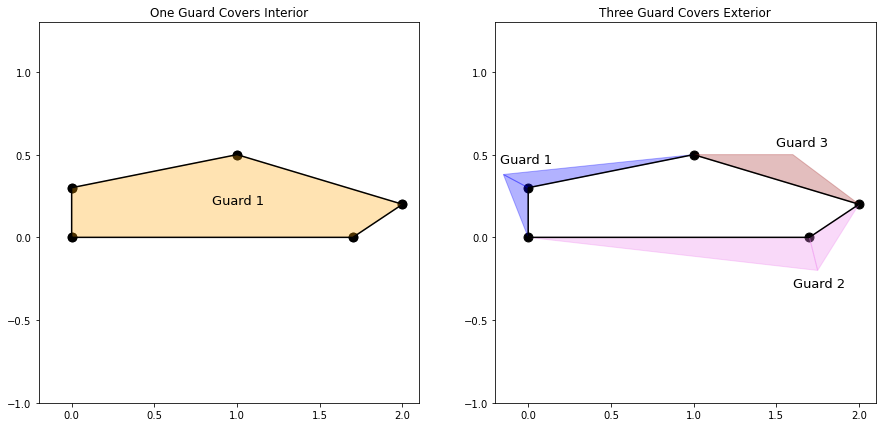

In [111]:
pentagon_coords = np.array([[0.0, 0.0],
                            [0.0, 0.3],
                            [1.0, 0.5],
                            [2.0, 0.2],
                            [1.7, 0.0]])

fig_2_5, ax = plt.subplots(1,2, figsize=(15, 7))
ax[0].scatter(pentagon_coords[:, 0], pentagon_coords[:, 1], s=70, c='k')
polygon = Polygon(pentagon_coords, color='orange', alpha=0.3)
ax[0].add_patch(polygon)
ax[0].text(0.85, 0.2, 'Guard 1', fontsize='13')
ax[0].set_title('One Guard Covers Interior')
ax[0].set_xlim(-0.2, 2.1)
ax[0].set_ylim(-1,1.3)

for axis in [ax[0],ax[1]]:
    axis.set_xlim(-0.2,2.1)
    axis.set_ylim(-1,1.3)
    axis.plot(closed_polygon_coords[...,0], closed_polygon_coords[...,1], c = 'black')
    axis.scatter(pentagon_coords[...,0], pentagon_coords[...,1], c = 'black', s=80)
    
ax[1].set_title('Three Guard Covers Exterior')
ax[1].text(-0.17,0.45, 'Guard 1', fontsize='13')
ax[1].text(1.6,-0.3, 'Guard 2', fontsize='13')
ax[1].text(1.5,0.55, 'Guard 3', fontsize='13')


# Guards sight triangles

g1_t1 = Polygon(np.concatenate((np.array([[-0.15,0.38]]),pentagon_coords[0:2])), color='blue', alpha = 0.3)
g1_t2 = Polygon(np.concatenate((np.array([[-0.15,0.38]]),pentagon_coords[1:3])), color='blue', alpha = 0.3)
ax[1].add_patch(g1_t1)
ax[1].add_patch(g1_t2)

g2_t1 = Polygon(np.concatenate((np.array([[1.75,-0.2]]),np.array([closed_polygon_coords[-2]]),np.array([closed_polygon_coords[0]]))), color='violet', alpha = 0.3)
g2_t2 = Polygon(np.concatenate((np.array([[1.75,-0.2]]),np.array([closed_polygon_coords[-2]]),np.array([closed_polygon_coords[-3]]))), color='violet', alpha = 0.3)
ax[1].add_patch(g2_t1)
ax[1].add_patch(g2_t2)

g3_t1 = Polygon(np.concatenate((np.array([[1.6,0.5]]),np.array([closed_polygon_coords[-3]]),np.array([closed_polygon_coords[-4]]))), color='brown', alpha = 0.3)
ax[1].add_patch(g3_t1)

plt.show()

## 3. Convex Hull
### 3.1 Definition:  Convex Rigions
- The smallest convex polygon that `contains all points` when there are multiple points

-  a region is convex if any two points of the region are visible to one another within the region.

![image](https://user-images.githubusercontent.com/83874157/130237345-55eefa53-2d03-4c1f-8509-d75cb0c6c4f8.png)

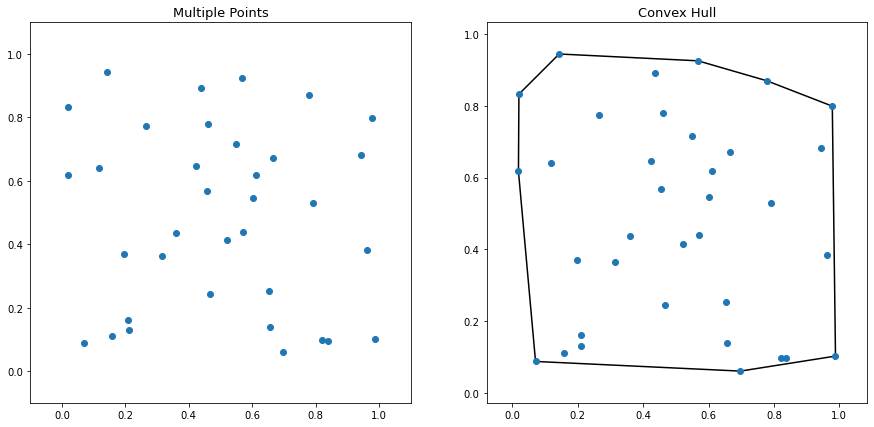

In [254]:
np.random.seed(0)
fig_3_1, ax = plt.subplots(1,2, figsize=(15,7))

random_multiple_points = np.random.random_sample((35,2))

ax[0].scatter(random_multiple_points[:,0], random_multiple_points[:,1])
ax[0].set_ylim(-0.1, 1.1)
ax[0].set_xlim(-0.1, 1.1)
ax[0].set_title('Multiple Points', fontsize=13)

hull = ConvexHull(random_multiple_points)
convex_hull = convex_hull_plot_2d(hull, ax=ax[1])
ax[1].set_title('Convex Hull', fontsize=13)

plt.show()